# Future City - Code

The steps of the project are the following:
<br><br>

1. <b>Data aggregation</b>

    a) We take a list of all cities with more than 1 million inhabitants in US, Canada and Europe from Wikipedia, e.g. https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population (in case these are too many requests in the later steps, we have to shrink down the number of cities)

    b) Nominatim of OSM allows us via json to catch the center coordinates and urban area polygons for the cities. A first idea was to use the database of geonames at https://download.geonames.org/export/dump/ in order to get all the postal code areas of these places together with coordinates and then merge them, but the names in wikipedia have to be translated into native languages (and "New York City" in Geonames is "New York").

    c) We explore all these areas in Foursquare. The account limits to 950.000 standard calls, which can be a search on coordinates. The answers include coordinates, so we can generate a hexagonal grid and get all the values. If there is a significant number of issues with missing coordinates we can replace this by a triangular grid and triangulate all the venues.
<br>

    
2. <b>Data exploration</b>

    a) The next part of the idea is to generate a kind of fingerprint for each city by information that can be visualized in histograms and other graphs. E.g. the density of restaurants depending on the distance to the center. Of course, another problem arises here which is that some cities might have a different number of "centers", but this might be represented by the fingerprint. And sure, distances are given due to a certain metric which is related to topology, infrastructure, no-go areas and so on (but this is out of the scope of this project). The different centers can be found using k-means and categorized to small, medium, large.

    b) Probably a spring model is a good approach to compare and cluster all the cities by the high-dimensional amount of data which, of course, needs to be normalized. The result can be plotted in 2d (a high-dimensional version of k-means is probably not doing a good job, but can be tried for fun).

    c) What are the differences between the cities? Is there a way to order them according to some dynamics, which shows their future classes with certain probabilities? This will be done properly, as soon as enough structure is found in the data. 
<br>


3. <b>Decision making based on data</b>

    a) We can learn from other cities about future evolution. And of course, additional information on all levels would be quite helpful to get a better ordering, but this is only a small project ;-) e.g. fingerprints of areas could be correlated to crime rates and types,....

    b) If the decision is made, towards which direction a city should move, we can make profit out of the differences. First of all, we have to option to move towards a city type that isn't existing yet. Second, moving towards an existing city doesn't mean we want to copy this city, we only copy certain characteristics.
    
    c) Finally, we also learn, which areas need more restaurants, hotels, cafes, what so ever. This information is important for companies to know where to invest and for politicians to observe the results of their decisions.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

As a first step, dependencies should be resolved.

In [158]:
import numpy as np # library to handle data in a vectorized manner
#
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#
import json # library to handle JSON files
#
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
#!conda install -c descartes --yes
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
#from shapely.geometry import MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon

#
from bs4 import BeautifulSoup
import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#
## Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors
import matplotlib.pyplot as plt
#
## import k-means from clustering stage
#from sklearn.cluster import KMeans
#
##!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library
#

from shapely import geometry # create polygonal shapes

%matplotlib notebook

print('Libraries imported.')

Libraries imported.


## Download and Explore Dataset

### Download data about the largest cities in North America and Europe from wikipedia.

In [2]:
def getLargestCities(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    # get relevant table
    table = soup.find(class_="wikitable")
    
    # get all rows
    rows = table.findChildren(['tr'])

    # get the headers
    cols=[]
    headers = rows[0].findChildren('th')
    for header in headers:
        cols.append(header.get_text(strip=True))
    
    cities=[]

    for row in rows:
        city = []
        cells = row.findChildren('td')
        for cell in cells:
            city.append(cell.get_text(strip=True))
            
        cities.append(city)

    df = pd.DataFrame(cities,columns=cols)
        
    return df


After catching data, it has to be cleaned.

In [3]:
def cleanCityData(df):
    # drop first row
    df.dropna(axis=0,inplace=True)

    if 'Officialpopulation' in df.columns: df.rename(columns={"Officialpopulation": "Population"},inplace=True)
    # remove the references in the population cells
    df["Population"]=df["Population"].apply(lambda x: x.split('[')[0])
    # remove the references in the year cells
    if 'Year' in df.columns: df["Year"]=df["Year"].apply(lambda x: x.split('[')[0])
    # rewrite the index
    df=df.reset_index(drop=True)
    # convert population to integer
    df["Population"]=df["Population"].str.replace(",","").astype("int")
    df["City"]=df["City"].str.split("[").str[0]
    return df

#    df = df[(df.Country=='Canada') | (df.Country=='United States')].reset_index(drop=True)


We are only interested in cities with more than 1 million inhabitants.

In [4]:
def relevantCityData(df):
    # take only relevant information for cities that have more than 1 million inhabitants
    df=df[df["Population"]>1000000][["City","Country","Population"]].reset_index(drop=True)
    return df

Catch data and show its original shape

In [5]:
dfNA=getLargestCities("https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population")
dfNA.head()

,,City,Image,Country,Population,Year
0,None,None,None,None,None,None
1,1,Mexico City,,Mexico,"8,918,653[a][3][4]",2015[b]
2,2,New York City,,United States,"8,550,405[5]",2015
3,3,Los Angeles,,United States,"3,971,883[5]",2015
4,4,Toronto,,Canada,"2,826,498[c][7]",2015


In [6]:
dfE=getLargestCities("https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits")
dfE.head()

,,City,Country,Officialpopulation,Date,2011 Eurostatpopulation[1],Image,Location,Ref.
0,None,None,None,None,None,None,None,None,None
1,1,Istanbul[a],Turkey,"15,067,724",31 December 2018,,,41°00′49″N28°57′18″E﻿ / ﻿41.013611°N 28.955°E﻿...,[2]
2,2,Moscow[b],Russia,"12,615,279",1 January 2019,,,55°45′00″N37°37′00″E﻿ / ﻿55.75°N 37.616667°E﻿ ...,[3]
3,3,London,United Kingdom,"9,126,366",31 December 2018,"8,173,941",,51°30′26″N0°07′39″W﻿ / ﻿51.507222°N 0.1275°W﻿ ...,[4]
4,4,Saint Petersburg,Russia,"5,383,890",1 January 2019,,,59°57′N30°18′E﻿ / ﻿59.95°N 30.3°E﻿ /59.95; 30....,[5][6]


Show the cleaned data. There is still a second "index" column and columns for image and year, data, location, ref that are not important for us

In [7]:
dfNA=cleanCityData(dfNA)
dfNA.head()

,,City,Image,Country,Population,Year
0,1,Mexico City,,Mexico,8918653,2015
1,2,New York City,,United States,8550405,2015
2,3,Los Angeles,,United States,3971883,2015
3,4,Toronto,,Canada,2826498,2015
4,5,Chicago,,United States,2720546,2015


In [8]:
dfE=cleanCityData(dfE)
dfE.head()

,,City,Country,Population,Date,2011 Eurostatpopulation[1],Image,Location,Ref.
0,1,Istanbul,Turkey,15067724,31 December 2018,,,41°00′49″N28°57′18″E﻿ / ﻿41.013611°N 28.955°E﻿...,[2]
1,2,Moscow,Russia,12615279,1 January 2019,,,55°45′00″N37°37′00″E﻿ / ﻿55.75°N 37.616667°E﻿ ...,[3]
2,3,London,United Kingdom,9126366,31 December 2018,"8,173,941",,51°30′26″N0°07′39″W﻿ / ﻿51.507222°N 0.1275°W﻿ ...,[4]
3,4,Saint Petersburg,Russia,5383890,1 January 2019,,,59°57′N30°18′E﻿ / ﻿59.95°N 30.3°E﻿ /59.95; 30....,[5][6]
4,5,Berlin,Germany,3748148,31 December 2018,"3,460,725",,52°31′00″N13°23′00″E﻿ / ﻿52.516667°N 13.383333...,[7]


Reduce to the relevant data.

In [9]:
dfNA=relevantCityData(dfNA)
dfNA.head()

,City,Country,Population
0,Mexico City,Mexico,8918653
1,New York City,United States,8550405
2,Los Angeles,United States,3971883
3,Toronto,Canada,2826498
4,Chicago,United States,2720546


In [10]:
dfE=relevantCityData(dfE)
dfE.head()

,City,Country,Population
0,Istanbul,Turkey,15067724
1,Moscow,Russia,12615279
2,London,United Kingdom,9126366
3,Saint Petersburg,Russia,5383890
4,Berlin,Germany,3748148


In the next step, we are going to use the OSM data to get the polygonal shapes of the cities. Unfortunately this data is not stored for all cities in the expected way. Therefore, we decided to concentrate on cities in US, Canada and Europe. Problems appear for most countries south of US and Australia. In order to solve these issues, a different dataset has to be used. For south asian countries similar problems appeared but may be solved by further investigation of translations of the character encodings. Istanbul has to be removed as well, because OSM does not offer the cities borders and the state is gigantic.

In [11]:
dfNA=dfNA[(dfNA.Country=='Canada') | (dfNA.Country=='United States')].reset_index(drop=True)

In [359]:
dfE=dfE[dfE.City!="Istanbul"].reset_index(drop=True)

Combine the datasets to a single one, sorted by population

In [360]:
df=dfNA.append(dfE).sort_values(by='Population', ascending=False).reset_index(drop=True)
df.head()

,City,Country,Population
0,Moscow,Russia,12615279
1,London,United Kingdom,9126366
2,New York City,United States,8550405
3,Saint Petersburg,Russia,5383890
4,Los Angeles,United States,3971883


### Fetch the polygonal data

OSM offers urban area polygonal data for all of the given cities. A json call can be used and answers with a list, where for some cases the first entry is the information about the city with the polygonal data, but in some cases this is only the information about the center of the city and the polygonal data is in the second entry. We will check if the information is in the first entry and if not use the second.

Unfortunately, the "wrong" entry has also polygonal data and in some cases the polygonal data of the "correct" entry is a nested list, so a simple count of the length of the list doesn't give a meaningful answer. In the case of Hamburg, the third element in the list is the correct one. The key geojson and the subkey coordinates exists in all elements

In [13]:
# now fetch the polygons for all the cities
def addPolygons(df,pos):
    df.iloc[pos]
    url = 'https://nominatim.openstreetmap.org/search.php?q={}+%2B{}&polygon_geojson=1&format=json'.format(
      df.loc[pos,"City"],
      df.loc[pos,"Country"]
    )
    
    answer = requests.get(url).json()
    
    for element in answer:
        if ('geojson' in element.keys()) & ('type' in element['geojson'].keys()):
            if ((df.loc[pos,"City"]=="Perm") & (element['type']=="administrative")):
                continue # sorry for this hack, but data is not always stored correctly
            if (element['geojson']['type']=='Point'):
                continue
            elif (element['geojson']['type']=='Polygon'): 
                return {'City':df.loc[pos,"City"],'Country':df.loc[pos,"Country"],'Population':df.loc[pos,"Population"], 'Latitude': float(element['lat']),'Longitude': float(element['lon']), 'boundingbox': [float(el) for el in element['boundingbox']], 'coordinates': Polygon(element['geojson']['coordinates'][0])}
            elif (element['geojson']['type']=='MultiPolygon'): 
                return {'City':df.loc[pos,"City"],'Country':df.loc[pos,"Country"],'Population':df.loc[pos,"Population"], 'Latitude': float(element['lat']),'Longitude': float(element['lon']), 'boundingbox': [float(el) for el in element['boundingbox']], 'coordinates': MultiPolygon([Polygon(element[0]) for element in element['geojson']['coordinates']])}
    return null



In [361]:
dfGeo=pd.DataFrame([addPolygons(df,i) for i in range(len(df))])

In [15]:
dfGeo.dtypes

City            object
Country         object
Latitude       float64
Longitude      float64
Population       int64
boundingbox     object
coordinates     object
dtype: object

In [362]:
dfGeo.head()

,City,Country,Latitude,Longitude,Population,boundingbox,coordinates
0,Moscow,Russia,55.750446,37.617494,12615279,"[55.4913076, 55.9577717, 37.290502, 37.9674277]","(POLYGON ((37.290502 55.8019897, 37.2932645 55..."
1,London,United Kingdom,51.489334,-0.144055,9126366,"[51.2867601, 51.6918741, -0.5103751, 0.3340155]","POLYGON ((-0.5103751 51.4680873, -0.5103637 51..."
2,New York City,United States,40.712728,-74.006015,8550405,"[40.477399, 40.9161785, -74.25909, -73.7001809]","(POLYGON ((-74.25909 40.497207, -74.259028 40...."
3,Saint Petersburg,Russia,59.938732,30.316229,5383890,"[59.7441481, 60.0907368, 30.0433427, 30.5671662]","POLYGON ((30.0433427 59.7641834, 30.0438245 59..."
4,Los Angeles,United States,34.053691,-118.242767,3971883,"[33.7036216, 34.337306, -118.6681776, -118.155...","POLYGON ((-118.6681776 34.185075, -118.6681703..."


In [363]:
dfBorders = gpd.GeoDataFrame(dfGeo, geometry='coordinates')
dfCenters = gpd.GeoDataFrame(dfGeo, geometry=gpd.points_from_xy(dfGeo.Longitude, dfGeo.Latitude))

In [364]:
dfBorders.head()

,City,Country,Latitude,Longitude,Population,boundingbox,coordinates,geometry
0,Moscow,Russia,55.750446,37.617494,12615279,"[55.4913076, 55.9577717, 37.290502, 37.9674277]","MULTIPOLYGON (((37.29050 55.80199, 37.29326 55...",POINT (37.61749 55.75045)
1,London,United Kingdom,51.489334,-0.144055,9126366,"[51.2867601, 51.6918741, -0.5103751, 0.3340155]","POLYGON ((-0.51038 51.46809, -0.51036 51.46795...",POINT (-0.14406 51.48933)
2,New York City,United States,40.712728,-74.006015,8550405,"[40.477399, 40.9161785, -74.25909, -73.7001809]","MULTIPOLYGON (((-74.25909 40.49721, -74.25903 ...",POINT (-74.00602 40.71273)
3,Saint Petersburg,Russia,59.938732,30.316229,5383890,"[59.7441481, 60.0907368, 30.0433427, 30.5671662]","POLYGON ((30.04334 59.76418, 30.04382 59.76239...",POINT (30.31623 59.93873)
4,Los Angeles,United States,34.053691,-118.242767,3971883,"[33.7036216, 34.337306, -118.6681776, -118.155...","POLYGON ((-118.66818 34.18507, -118.66817 34.1...",POINT (-118.24277 34.05369)


In [365]:
dfCenters.head()

,City,Country,Latitude,Longitude,Population,boundingbox,coordinates,geometry
0,Moscow,Russia,55.750446,37.617494,12615279,"[55.4913076, 55.9577717, 37.290502, 37.9674277]","MULTIPOLYGON (((37.29050 55.80199, 37.29326 55...",POINT (37.61749 55.75045)
1,London,United Kingdom,51.489334,-0.144055,9126366,"[51.2867601, 51.6918741, -0.5103751, 0.3340155]","POLYGON ((-0.51038 51.46809, -0.51036 51.46795...",POINT (-0.14406 51.48933)
2,New York City,United States,40.712728,-74.006015,8550405,"[40.477399, 40.9161785, -74.25909, -73.7001809]","MULTIPOLYGON (((-74.25909 40.49721, -74.25903 ...",POINT (-74.00602 40.71273)
3,Saint Petersburg,Russia,59.938732,30.316229,5383890,"[59.7441481, 60.0907368, 30.0433427, 30.5671662]","POLYGON ((30.04334 59.76418, 30.04382 59.76239...",POINT (30.31623 59.93873)
4,Los Angeles,United States,34.053691,-118.242767,3971883,"[33.7036216, 34.337306, -118.6681776, -118.155...","POLYGON ((-118.66818 34.18507, -118.66817 34.1...",POINT (-118.24277 34.05369)


In [20]:
%matplotlib notebook


In [21]:
# create a map
m = folium.Map(location=[0,0],tiles='Stamen Toner', zoom_start=3)

## add chloropleth layer
m.choropleth(
    geo_data=gdf.geometry,
    name='Population',
    data=gdf,
    columns=['Population'],
    fill_color='YlGn',
    key_on='feature.geometry.name',
    legend_name='inc_tax_per_capita'
)  

# enable layers to be turned in or out
folium.LayerControl().add_to(m)

NameError: name 'gdf' is not defined

In [ ]:
dfBorders.coordinates.head()

In [ ]:
dfBorders.dtypes

In [ ]:
dfGeo.coordinates.head()

In [ ]:
dfGeo.dtypes

In [ ]:
dfBorders.coordinates.plot()

Import the world map and exclude the Antartica

In [366]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Plot the locations of all cities onto the world map

<IPython.core.display.Javascript object>


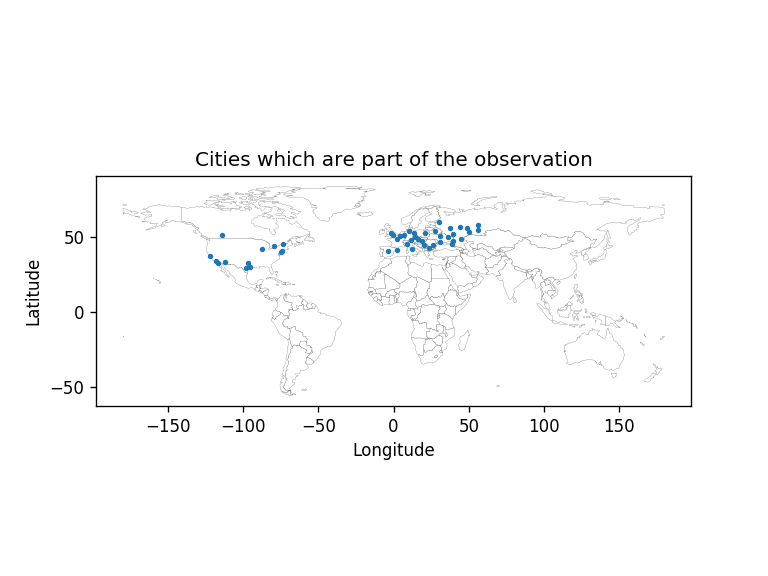

In [389]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black',linewidth=.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities which are part of the observation')
dfCenters.plot(ax=ax,markersize=5)

Plot the urban borders of all cities in Europe except for the russian ones

<IPython.core.display.Javascript object>


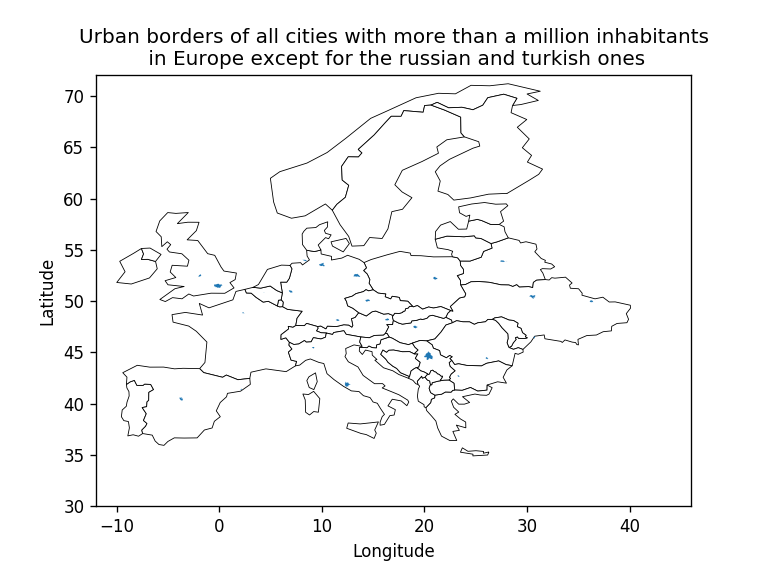

In [392]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
world[(world.continent=="Europe")&(world.name!="Russia")].plot(ax=ax, color='white', edgecolor='black',linewidth=.5)
ax.set_xlim([-12,46])
ax.set_ylim([30,72])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Urban borders of all cities with more than a million inhabitants\n in Europe except for the russian and turkish ones')
dfBorders[dfBorders.Country!="Russia"].plot(ax=ax,markersize=5)

Same for russian cities

<IPython.core.display.Javascript object>


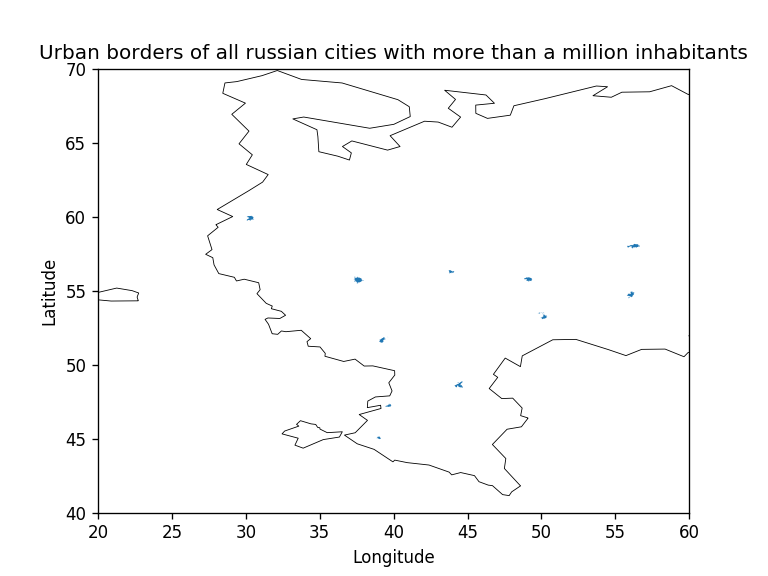

In [393]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
world[(world.name=="Russia")].plot(ax=ax, color='white', edgecolor='black',linewidth=.5)
ax.set_xlim([20,60])
ax.set_ylim([40,70])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Urban borders of all russian cities with more than a million inhabitants')
dfBorders[dfBorders.Country=="Russia"].plot(ax=ax,markersize=5)

In [369]:
dfBorders[dfBorders.Country=="United States"]

,City,Country,Latitude,Longitude,Population,boundingbox,coordinates,geometry
2,New York City,United States,40.712728,-74.006015,8550405,"[40.477399, 40.9161785, -74.25909, -73.7001809]","MULTIPOLYGON (((-74.25909 40.49721, -74.25903 ...",POINT (-74.00602 40.71273)
4,Los Angeles,United States,34.053691,-118.242767,3971883,"[33.7036216, 34.337306, -118.6681776, -118.155...","POLYGON ((-118.66818 34.18507, -118.66817 34.1...",POINT (-118.24277 34.05369)
10,Chicago,United States,41.875562,-87.624421,2720546,"[41.644531, 42.0230396, -87.940101, -87.5240812]","POLYGON ((-87.94010 42.00093, -87.94003 41.998...",POINT (-87.62442 41.87556)
11,Houston,United States,29.758938,-95.367697,2296224,"[29.5370705, 30.1103506, -95.9097419, -95.0120...","MULTIPOLYGON (((-95.26821 29.95456, -95.26831 ...",POINT (-95.36770 29.75894)
21,Philadelphia,United States,39.952724,-75.163526,1567442,"[39.867005, 40.1379593, -75.2802977, -74.9558314]","POLYGON ((-75.28030 39.97500, -75.28022 39.974...",POINT (-75.16353 39.95272)
22,Phoenix,United States,33.448437,-112.074142,1563025,"[33.2903739, 33.9183794, -112.3240289, -111.92...","POLYGON ((-112.32403 33.50969, -112.32403 33.5...",POINT (-112.07414 33.44844)
23,San Antonio,United States,29.424600,-98.495141,1469845,"[29.1862572, 29.7309623, -98.8131865, -98.2230...","MULTIPOLYGON (((-98.81319 29.56150, -98.81102 ...",POINT (-98.49514 29.42460)
27,San Diego,United States,32.717421,-117.162771,1394928,"[32.5347839, 33.114249, -117.3098053, -116.905...","POLYGON ((-117.30981 32.71290, -117.29773 32.6...",POINT (-117.16277 32.71742)
29,Dallas,United States,32.776272,-96.796856,1300092,"[32.613216, 33.0239366, -97.000482, -96.4636317]","MULTIPOLYGON (((-97.00048 32.62221, -96.99988 ...",POINT (-96.79686 32.77627)
43,San Jose,United States,37.336191,-121.890583,1026908,"[37.124503, 37.4692175, -122.045672, -121.589153]","POLYGON ((-122.04567 37.44902, -122.04566 37.4...",POINT (-121.89058 37.33619)


<IPython.core.display.Javascript object>


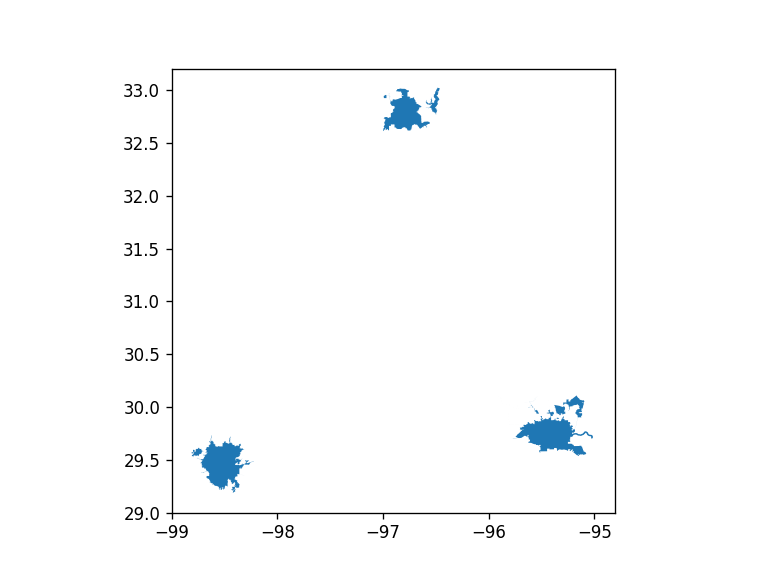

In [370]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
#world[(world.continent=="North America")&(world.name!="Greenland")].plot(ax=ax, color='white', edgecolor='black',linewidth=.5)
ax.set_xlim([-99,-94.8])
ax.set_ylim([29,33.2])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Urban borders of all cities with more than a million inhabitants\n in Europe except for the russian and turkish ones')
dfBorders[(dfBorders.Country=="Canada")|(dfBorders.Country=="United States")].plot(ax=ax,markersize=5)

Houston


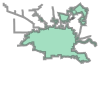

In [372]:
print (dfBorders.iloc[11].City)
dfBorders.iloc[11].coordinates

San Antonio


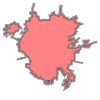

In [373]:
print(dfBorders.loc[23].City)
dfBorders.iloc[23].coordinates

Dallas


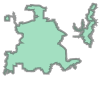

In [374]:
print(dfBorders.loc[29].City)
dfBorders.iloc[29].coordinates

In [ ]:
https://varunpant.com/posts/how-to-create-fishnets-or-geospatial-grids/

In [ ]:
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0],  crs=crs, geometry=gdfBorders.coordinates)

testMap = folium.Map(location=[0, 0], zoom_start=10)

folium.GeoJson(polygon).add_to(testMap)

The idea of the grid constructing function is the following:

1. Move to the first point in the grid
    1. Start with the minimal values for longitude and latitude in the bounding box of a city (this is South-West)
    2. Move North along the longitude (latitude gets larger) by the distance of the radius
    3. Move East along the latitude (longitude gets larger) by the distance of the radius


2. Generate all rows
    1. Repeat if we are still in the bounding box
    2. Generate all points in a row
        1. Repeat if we are still in the bounding box
        2. Add this point to the list, if it is in the city polygon
        3. Move East along the latitude (longitude gets larger) by the distance of twice the radius
        4. Goto a
    3. Move East to the point between the starting point in the row and the potential second point
    4. Move North by Sqrt(3)*radius, because: (sqrt(3)*r)^2+r^2= 4*r^2, which means that the distance of that point and the first potential point in the old row are seperated by twice the radius, as well as the distance to the second potential point in the old row
    5. For every second row, move West by twice the radius (if not we would drift to the East and have a triangular shape)
    6. Goto A
 
 
- Moving along the longitute means moving along a circle where the radius equals the circumference of the earth. 
- Moving along the latitude depends on the position of that latitude, they are factorized by the cos of the lateral angle
- For our purpose the earth is locally flat

In [343]:
def calculateGrid(city,radius):
    U=40075
    lonMin=min(city['boundingbox'][2],city['boundingbox'][3])
    lonMax=max(city['boundingbox'][2],city['boundingbox'][3])
    latMin=min(city['boundingbox'][0],city['boundingbox'][1])
    latMax=max(city['boundingbox'][0],city['boundingbox'][1])
    
    pointList=[]
    
    latPos=latMin+360*radius/U
    deltaLon=360*radius/(U*abs(np.cos(2*np.pi/360*latPos)))
    lonPos=lonMin+deltaLon
    
    odd=False
    
    while (latPos<=latMax):
        
        
        # how many circles with a length that is the double radius fit into the inverval starting deltaLon left
        # from lonPos and ending at lonMax
        number=int((lonMax-lonPos+deltaLon)/(2*deltaLon))
        
        row=[]
    
        # check if the points are inside the polygonal borders
        for i in range(number+1):
            if city.coordinates.geom_type=='Polygon':
                # check if the points are inside the polygonal borders
                if city.coordinates.contains(Point(lonPos+2*i*deltaLon,latPos,)):
                    row.append((latPos,lonPos+2*i*deltaLon))
            # polygonal borders are a multigonal for some cities
            else:
                for poly in city.coordinates:
                    if poly.contains(Point(lonPos+2*i*deltaLon,latPos)):
                        row.append((latPos,lonPos+2*i*deltaLon))
                        break
    
        # add new row to the point list
        pointList=pointList+row
        
        # move to next starting position
        lonPos=lonPos+deltaLon
        latPos=latPos+360*radius*np.sqrt(3)/U
    
        # calculate deltaLon as lateral position has changed
        deltaLon=360*radius/abs(U*np.cos(2*np.pi/360*latPos))
        #
        
        # move west every second row
        if odd: lonPos=lonPos-2*deltaLon
    
        # alternate
        odd=not odd
        
    return pointList

In [384]:
[len(calculateGrid(dfBorders.iloc[i],1)) for i in range(len(dfBorders))]

[298,
 455,
 351,
 170,
 394,
 254,
 242,
 176,
 372,
 192,
 175,
 473,
 28,
 72,
 105,
 280,
 121,
 149,
 134,
 152,
 30,
 109,
 394,
 409,
 102,
 89,
 54,
 285,
 150,
 297,
 92,
 181,
 44,
 250,
 80,
 5,
 161,
 930,
 209,
 102,
 117,
 174,
 236,
 141,
 244,
 46,
 72]

<IPython.core.display.Javascript object>


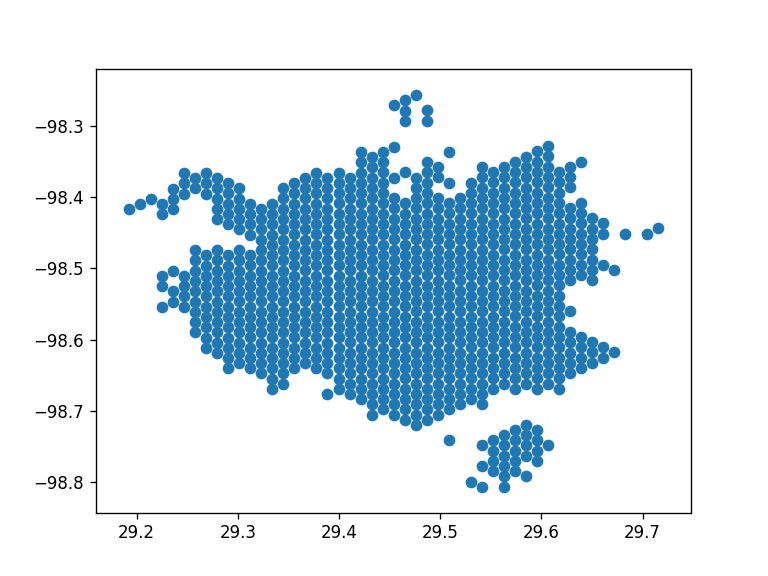

In [383]:
plt.scatter(*zip(*calculateGrid(dfBorders.iloc[23],.7)))

<IPython.core.display.Javascript object>


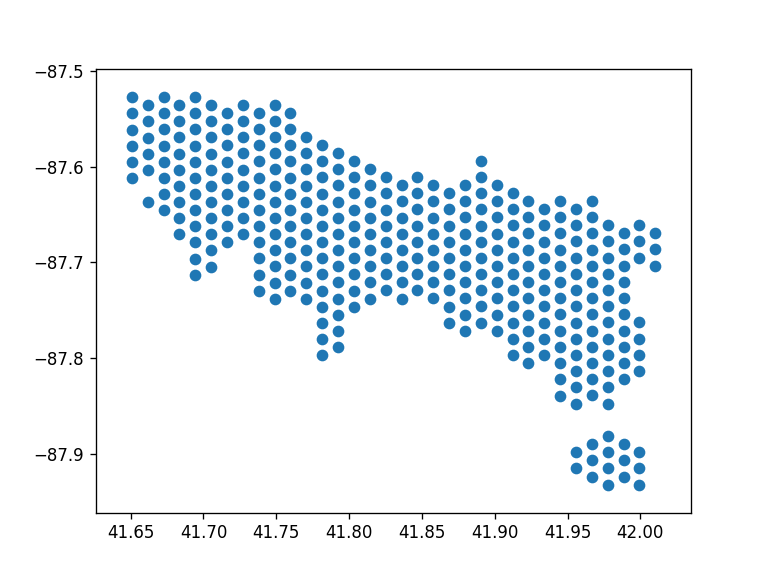

In [394]:
plt.scatter(*zip(*calculateGrid(dfBorders.iloc[10],.7)))

In [404]:
chicagoGrid=calculateGrid(dfBorders.iloc[10],.7)

In [445]:
dfGeo.iloc[10].City

'Chicago'

In [448]:
def showGridOnMap(index,radius):
    grid=calculateGrid(dfBorders.iloc[index],radius)
    m = folium.Map(location=[dfGeo.iloc[index].Latitude,dfGeo.iloc[index].Longitude],zoom_start=9,width=400, height=400)

    title_html = '''
             <h3 align="left" style="font-size:20px"><b>Grid for {} with radius={} km</b></h3>
             '''.format(dfGeo.iloc[index].City,radius)
    m.get_root().html.add_child(folium.Element(title_html))
    
    # add each city POLYGON
    if dfGeo.iloc[index].coordinates.geom_type=='Polygon':
        folium.Choropleth(geo_data=dfGeo.iloc[index].coordinates, fill_color='#e67e22').add_to(m)
    else :
        [folium.Choropleth(geo_data=polygon, fill_color='#e67e22').add_to(m) for polygon in dfGeo.iloc[index].coordinates]

    # add each capital city POINT
    [folium.Circle(location=p, radius=.4).add_to(m) for p in grid]

    return m


In [447]:
showGridOnMap(1,.7)

In [449]:
showGridOnMap(0,.7)